In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.optim as optim
import time

/var/folders/r6/3v3hctrx2j55w4422hhfxq7w0000gn/T/ipykernel_48976/3527029121.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load and preprocess data
df = pd.read_csv('names.txt', header=None)

In [3]:
df

,0
0,emma
1,olivia
2,ava
3,isabella
4,sophia
...,...
32028,zylas
32029,zyran
32030,zyrie
32031,zyron


In [4]:
input_data = [name.lower() for name in df[0]]
input_data = [name.replace(' ', '') for name in input_data]
input_data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
output_data = [name[1:]+'.'.lower() for name in df[0]]

In [6]:
output_data = [name.replace(' ', '') for name in output_data]

In [7]:
output_data[:10]

['mma.',
 'livia.',
 'va.',
 'sabella.',
 'ophia.',
 'harlotte.',
 'ia.',
 'melia.',
 'arper.',
 'velyn.']

In [8]:
ltoi = {char:idx for idx, char in enumerate(string.ascii_lowercase)}
itol = {idx:char for idx, char in enumerate(string.ascii_lowercase)}

In [9]:
ltoi['.'] = 26
itol[26] = '.'

In [10]:
ltoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '.': 26}

In [11]:
def tensorise_sequence(seq):
    output = torch.tensor([])
    for idx in range(len(seq)):
        tensor_l = torch.tensor(ltoi[seq[idx]])
        output = torch.cat((output, F.one_hot(tensor_l, 27)), dim=0)
    return output

In [12]:
tensorise_sequence('z')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.f_g = nn.Linear(input_size + hidden_size, hidden_size)
        self.u_f_g = nn.Linear(input_size + hidden_size, hidden_size)
        self.u_u_g = nn.Linear(input_size + hidden_size, hidden_size)
        self.o_i_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.h_o = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden, cell_state):
        x = torch.sigmoid(self.f_g(torch.cat((input, hidden), dim=1)))
        c = x * cell_state
        u_g = torch.sigmoid(self.u_f_g(torch.cat((input, hidden), dim=1))) * torch.tanh(self.u_u_g(torch.cat((input, hidden), dim=1)))
        c = c + u_g
        hidden = torch.tanh(c) * torch.sigmoid(self.o_i_f(torch.cat((input, hidden), dim=1)))
        output = self.h_o(hidden)
        return output, hidden, c
    def initHidden(self):
        return torch.zeros([1, self.hidden_size])
    def initCellState(self):
        return torch.zeros([1, self.hidden_size])

In [24]:
lstm = LSTM(27, 128, 27)

In [25]:
epochs = 10
total_loss = 0.0
running_loss = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
time_before_epoch = time.time()
for e in range(epochs):
    for i in range(len(input_data)):
        loss = torch.tensor(0.0)
        hidden = lstm.initHidden()
        cell_state = lstm.initCellState()
        input = input_data[i]
        target = output_data[i]
        lstm.zero_grad()
        for _i in range(len(input)):
            output, hidden, cell_state = lstm(tensorise_sequence(input[_i]).view(1, 27), hidden, cell_state)
            l = criterion(output.view(-1), tensorise_sequence(target[_i]))
            loss = loss + l
            # if _i == len(input) - 1:
            #     total_loss = total_loss / len(input)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)        
        # for p in rnn.parameters():
        #     print(p.grad.data)
        # print("New \n\n")
        optimizer.step()
        total_loss += l.item()
    time_after_epoch = round(time.time() - time_before_epoch, 0)
    time_after_epoch_m = time_after_epoch // 60
    time_after_epoch_s = time_after_epoch % 60
    print(f"Epoch {e}: Time Elapsed: {time_after_epoch_m}m{time_after_epoch_s}s Loss: {total_loss / len(input_data)}")
    total_loss = 0.0     


Epoch 0: Time Elapsed: 1.0m2.0s Loss: 0.7054368835534087
Epoch 1: Time Elapsed: 2.0m9.0s Loss: 0.6396635986873687
Epoch 2: Time Elapsed: 3.0m19.0s Loss: 0.6048828590137015
Epoch 3: Time Elapsed: 4.0m29.0s Loss: 0.5785563547933976
Epoch 4: Time Elapsed: 18.0m40.0s Loss: 0.5568447395312361
Epoch 5: Time Elapsed: 19.0m52.0s Loss: 0.5386974516855964
Epoch 6: Time Elapsed: 21.0m6.0s Loss: 0.5222754387438282
Epoch 7: Time Elapsed: 22.0m23.0s Loss: 0.5066715431447403
Epoch 8: Time Elapsed: 23.0m43.0s Loss: 0.493198183736194
Epoch 9: Time Elapsed: 25.0m5.0s Loss: 0.48063348019699914


otavio
True 



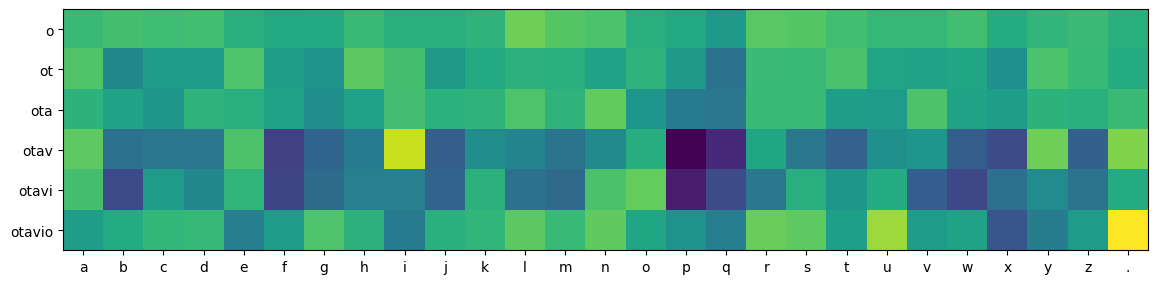

zaheer
True 



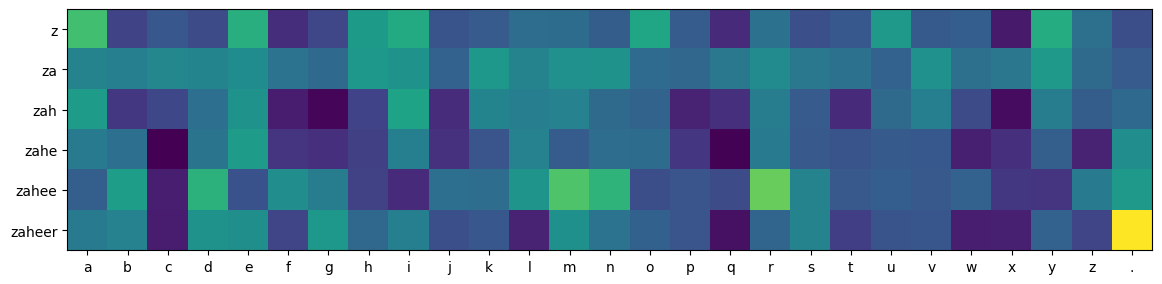

engel
True 



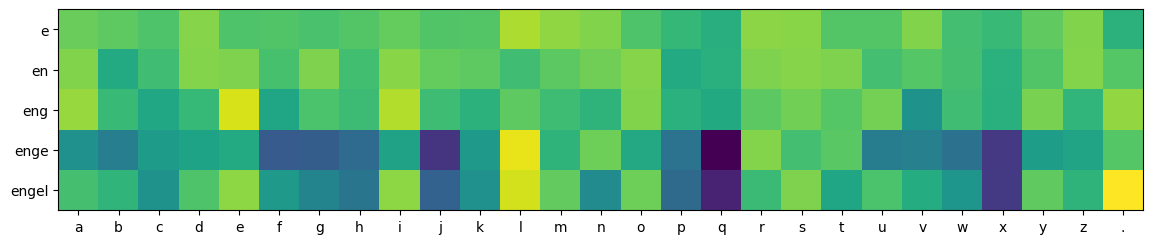

deven
True 



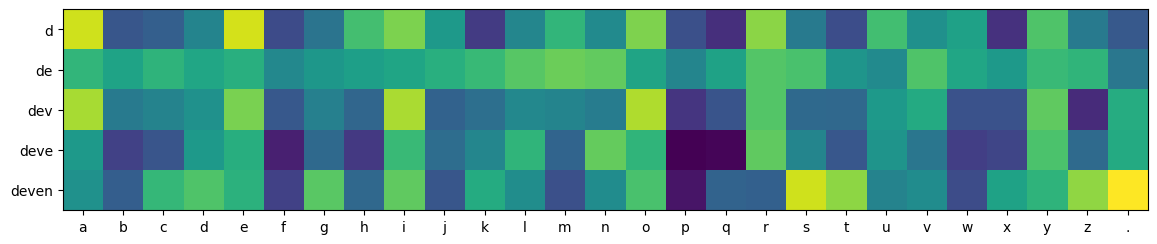

umua
False 



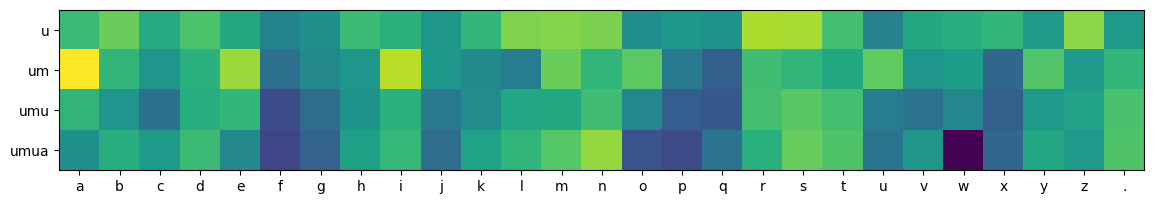

bregton
False 



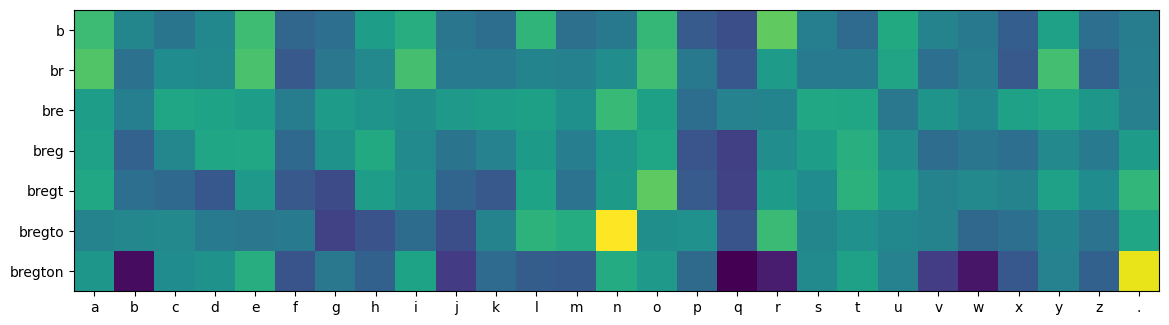

yaser
True 



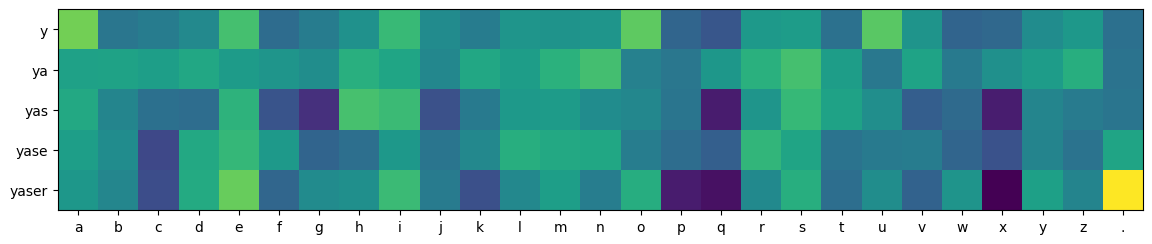

hapdi
False 



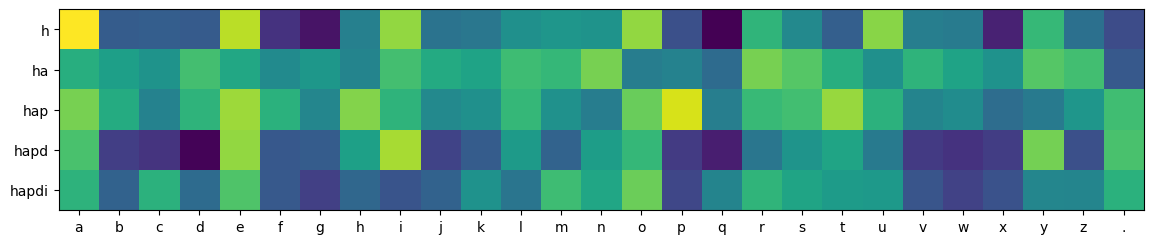

xrayneng
False 



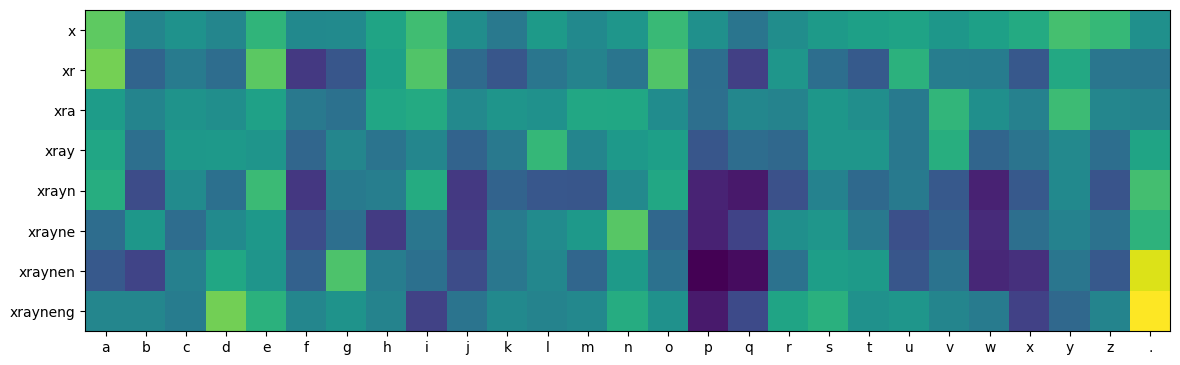

hennet
False 



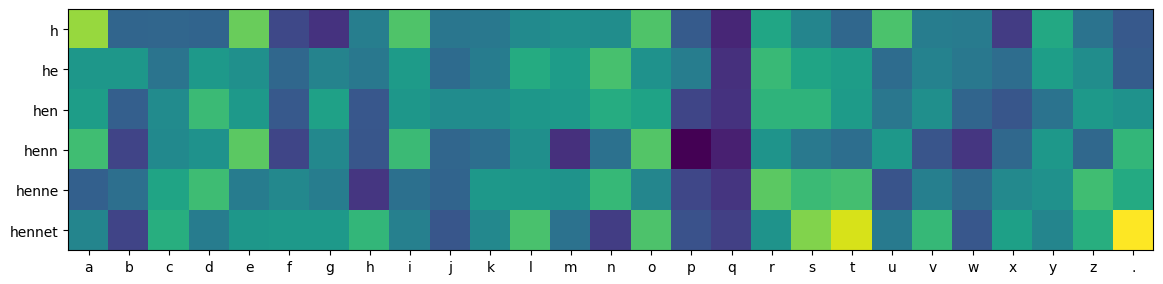

ocenolle
False 



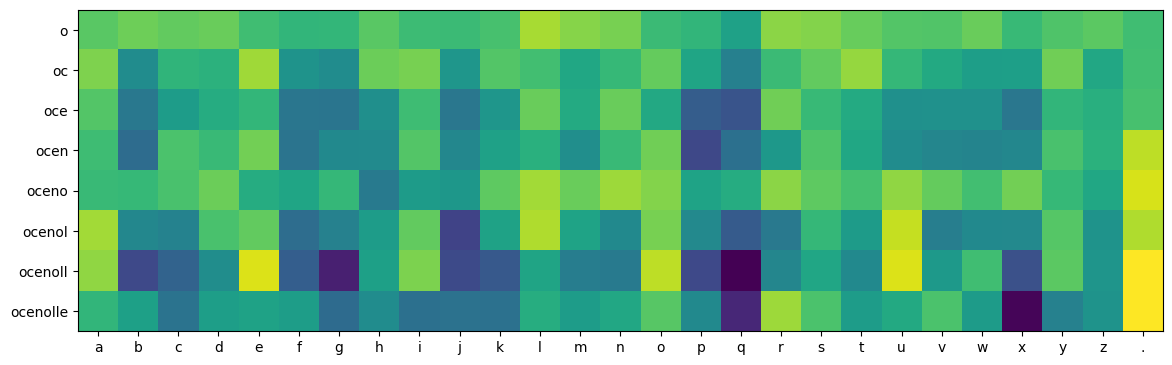

wit
False 



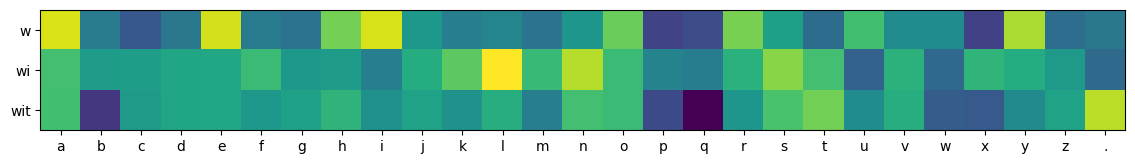

vieross
False 



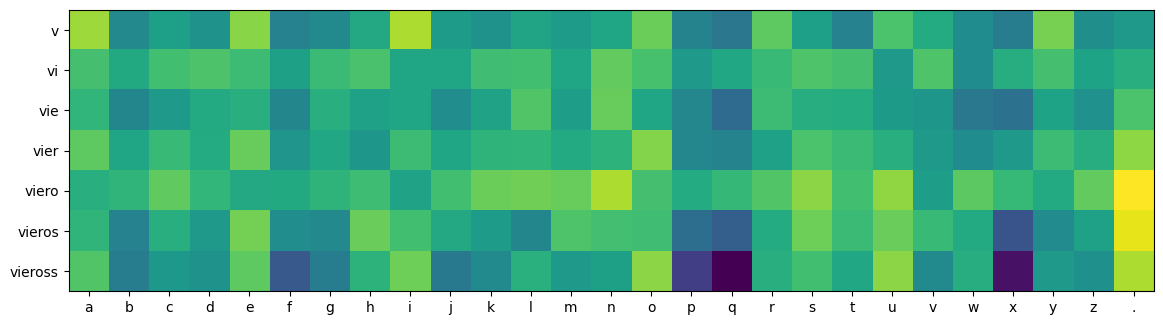

veyan
False 



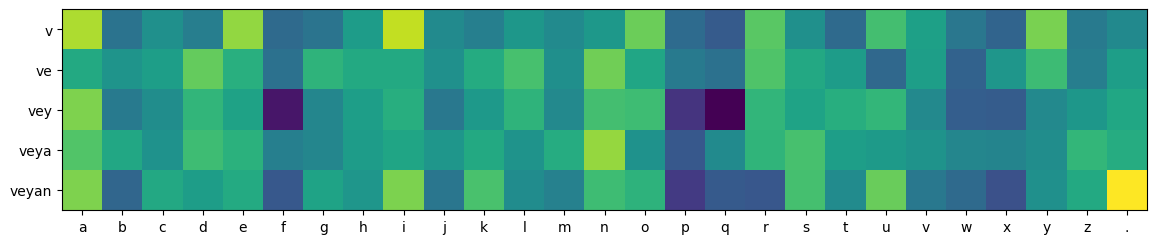

olii
False 



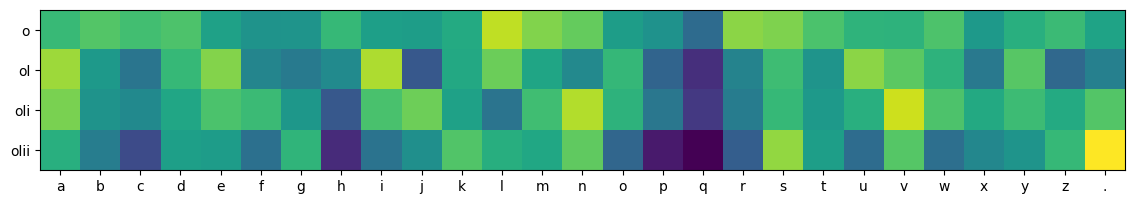

kaspan
False 



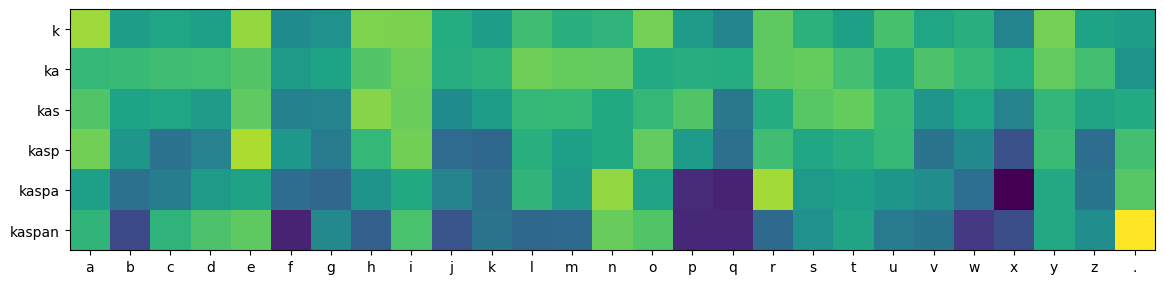

fane
False 



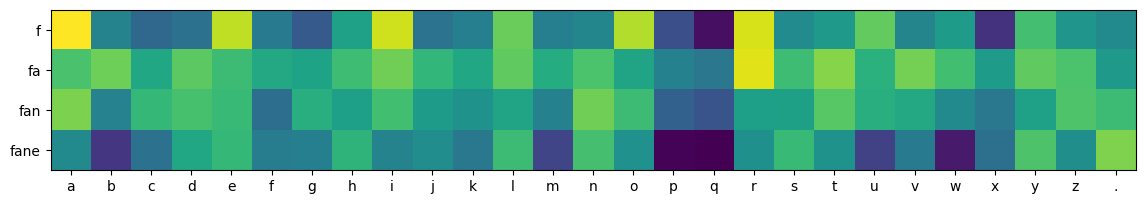

finncere
False 



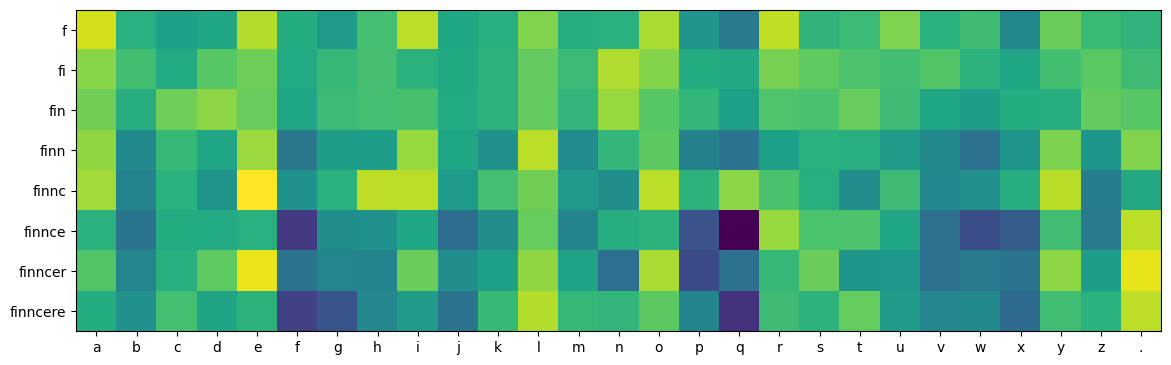

urwann
False 



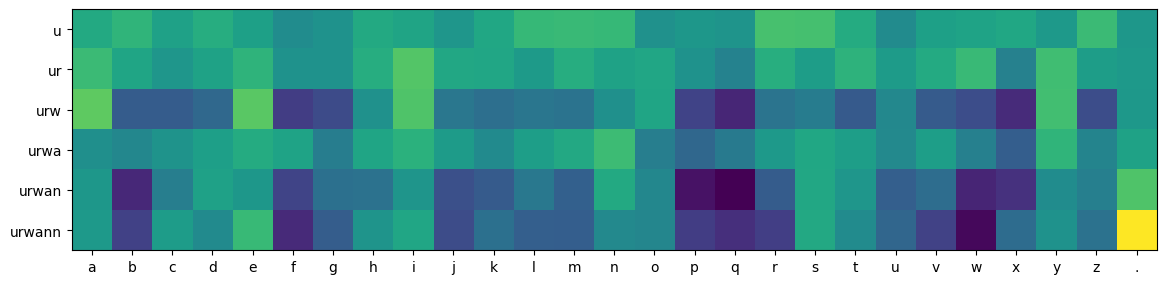

elivie
False 



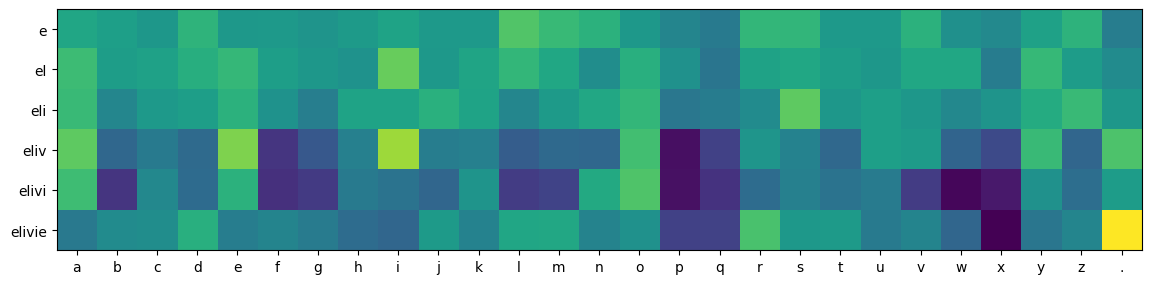

rodiwy
False 



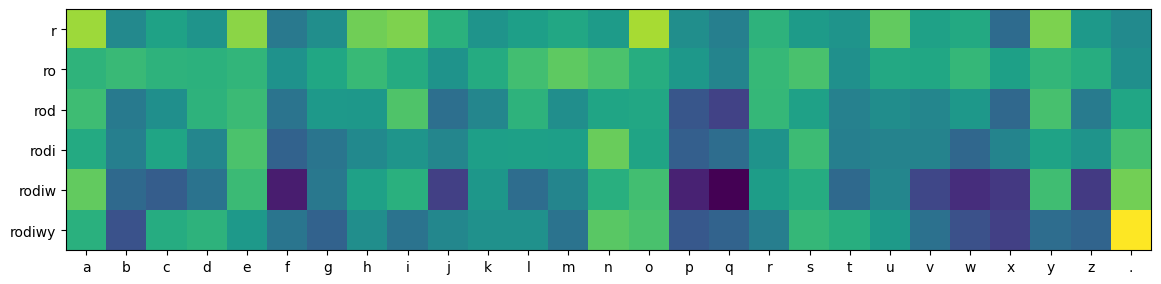

eadiel
False 



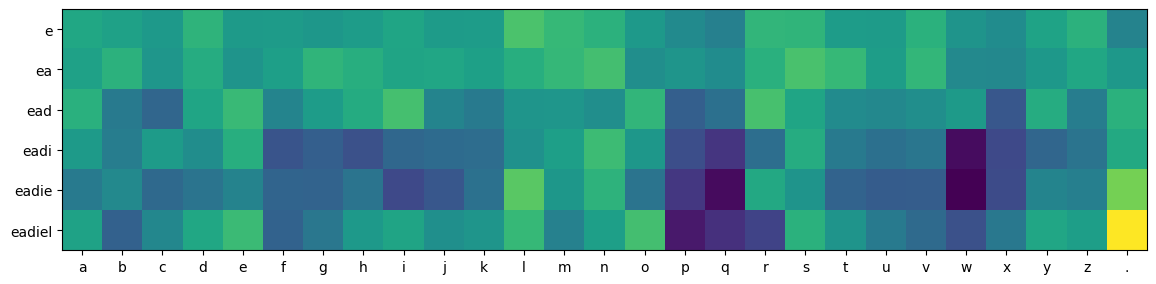

eovan
False 



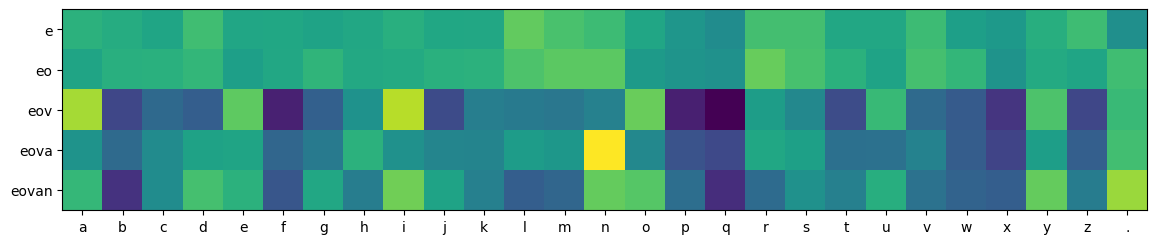

oed
False 



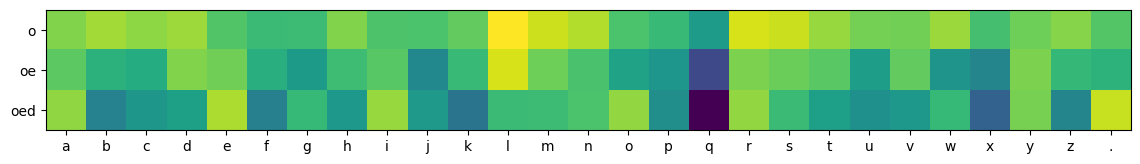

xayge
False 



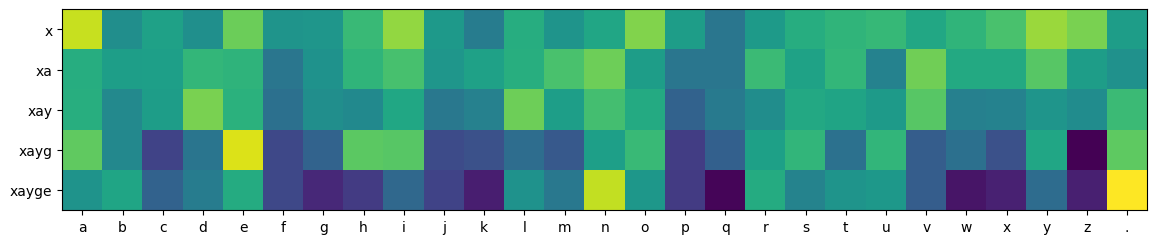

gurvelmae
False 



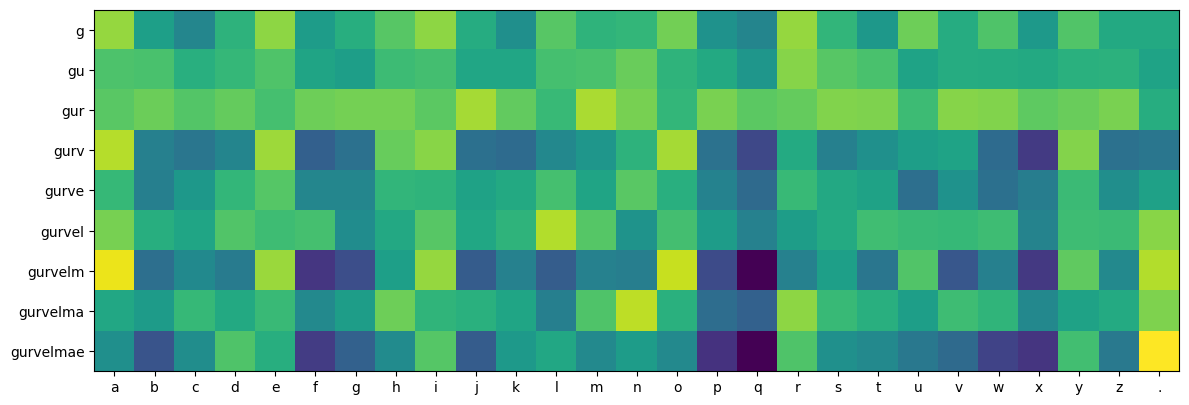

shence
False 



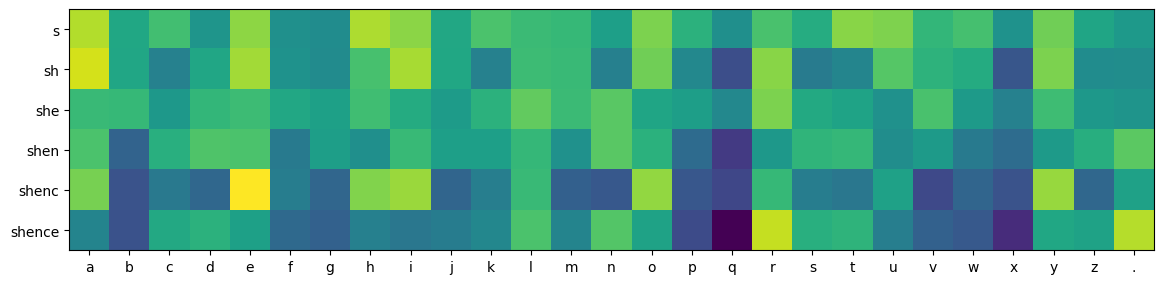

riyem
False 



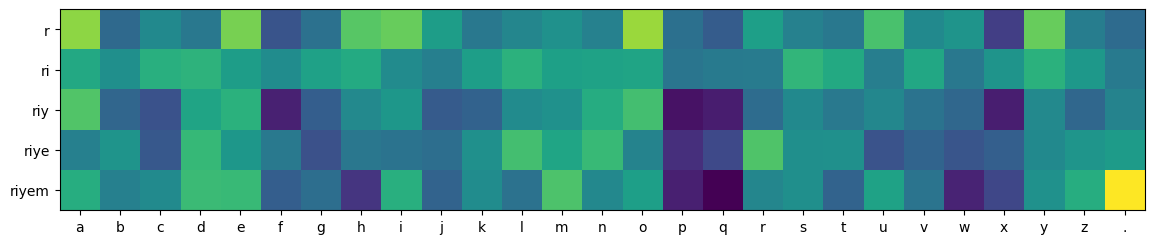

bry
False 



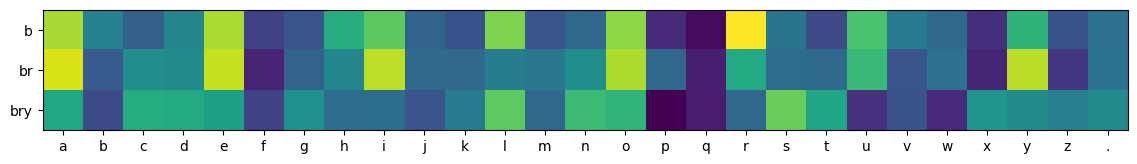

iraf
False 



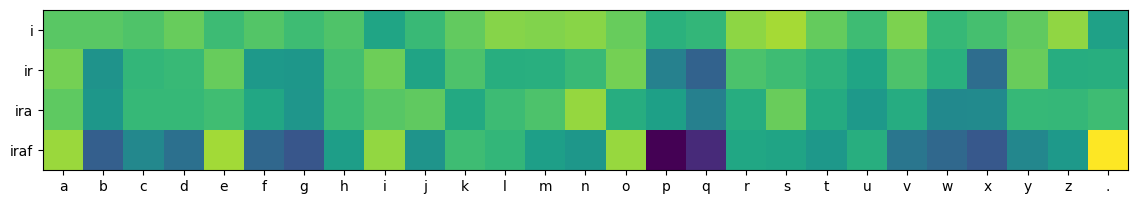

getse
False 



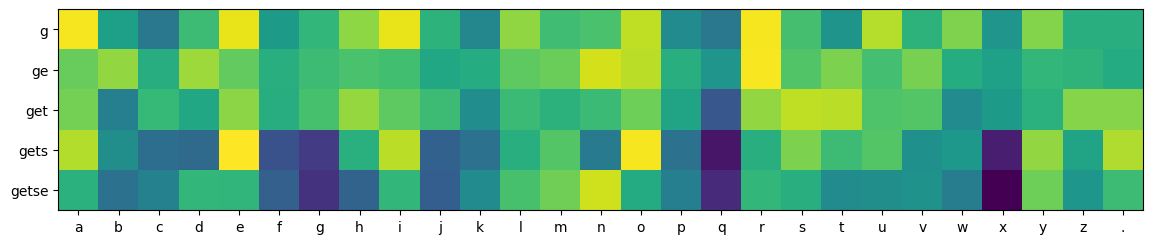

omyri
False 



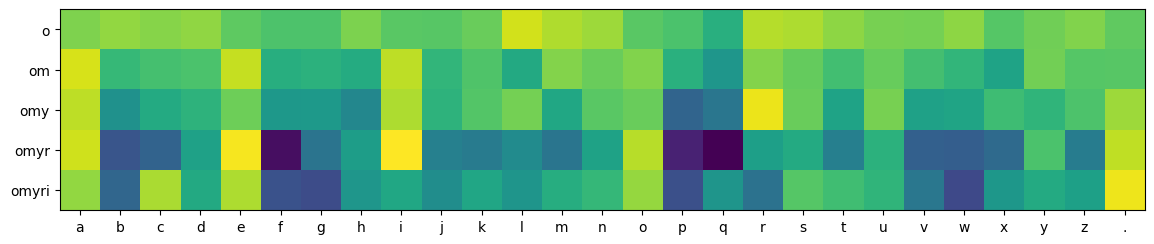

temon
False 



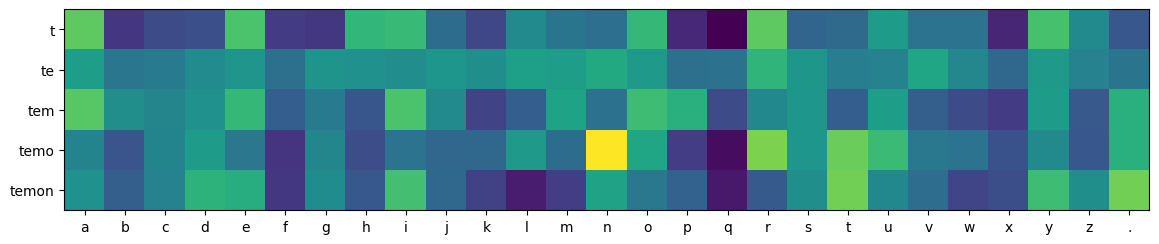

robar
False 



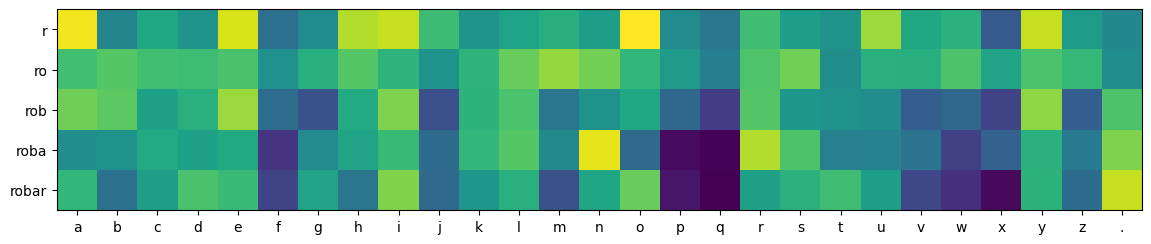

mry
False 



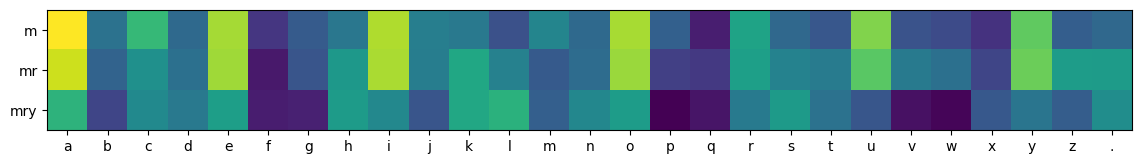

saniuh
False 



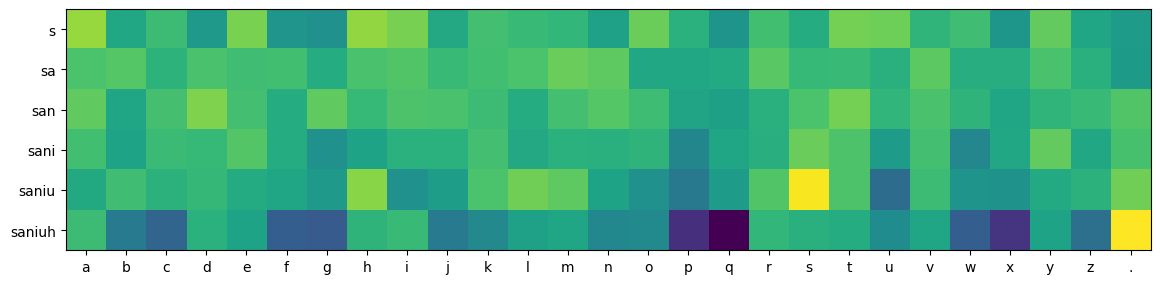

dy
False 



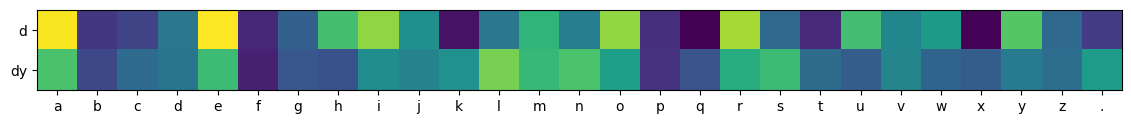

rudson
False 



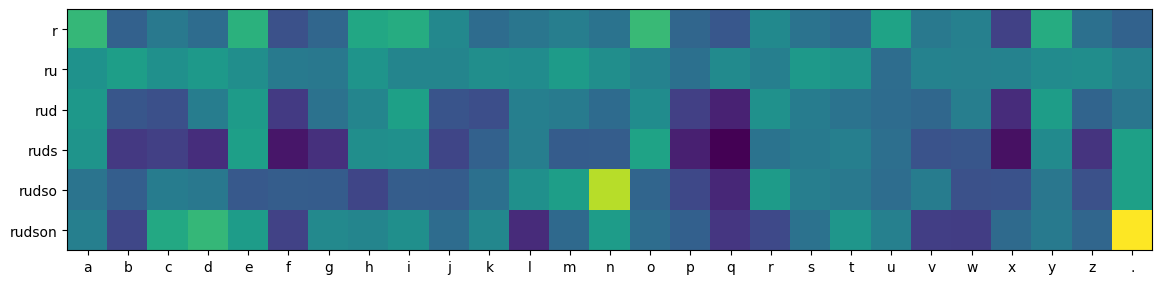

yu
True 



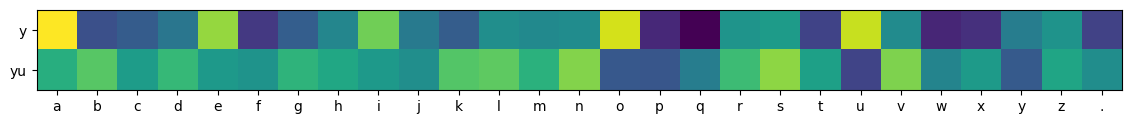

rahim
True 



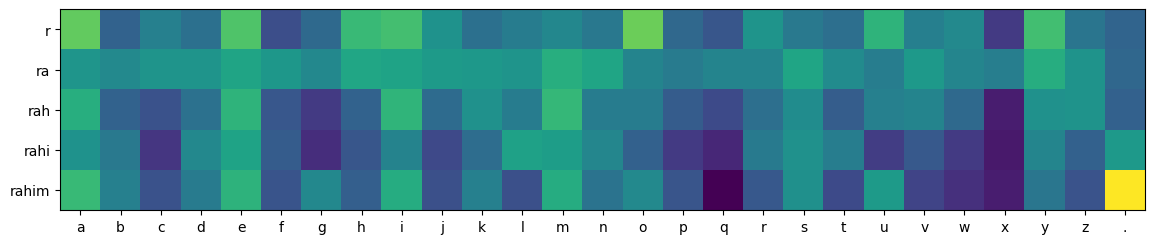

fay
True 



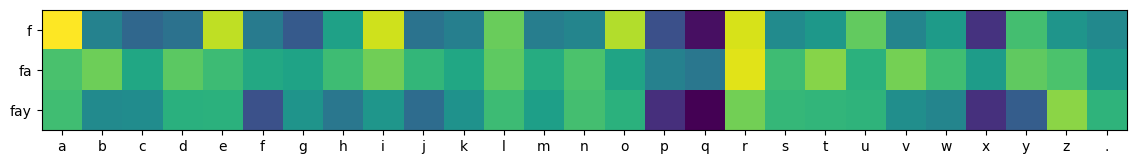

xavier
True 



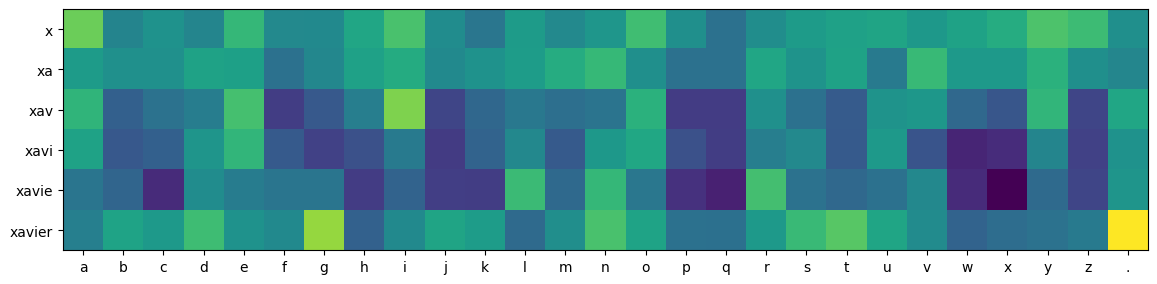

edgard
True 



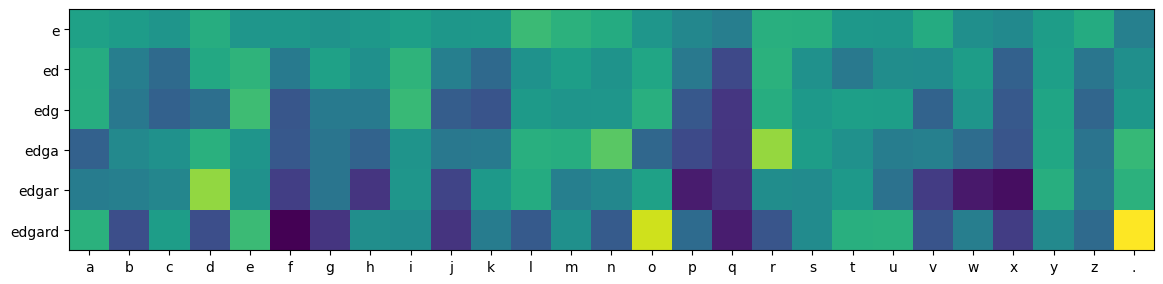

hadvon
False 



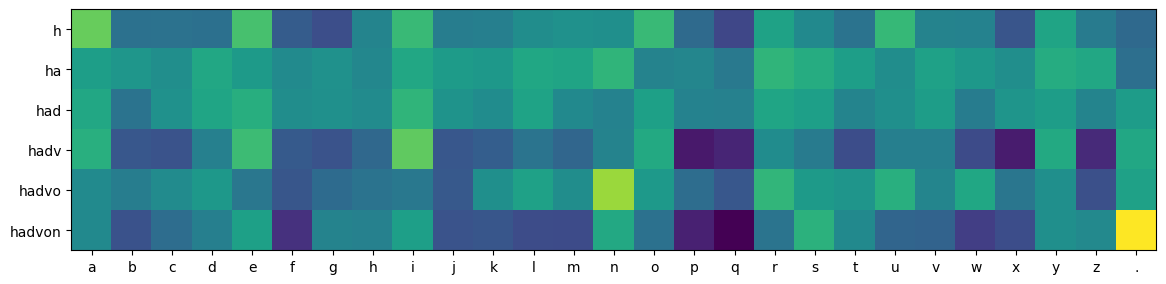

oudris
False 



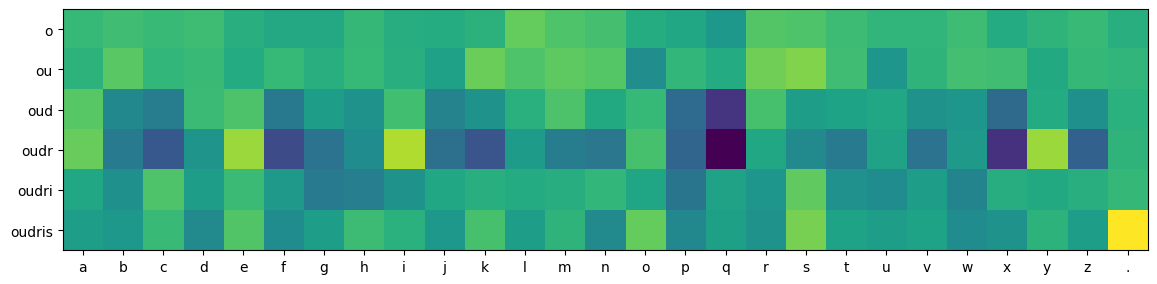

gotzer
False 



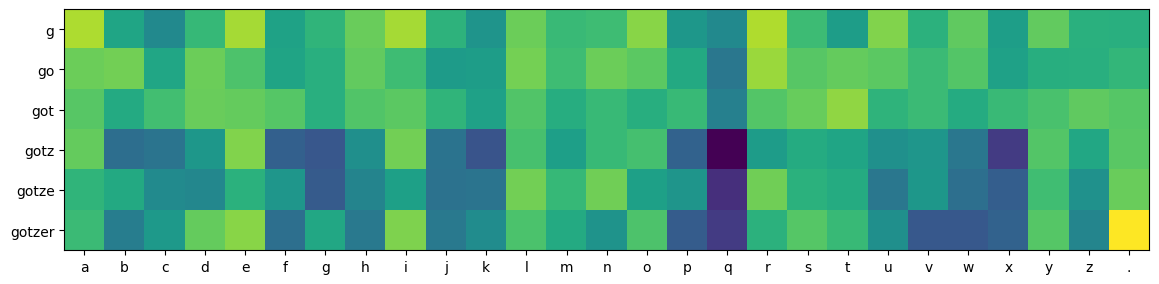

yuxiel
False 



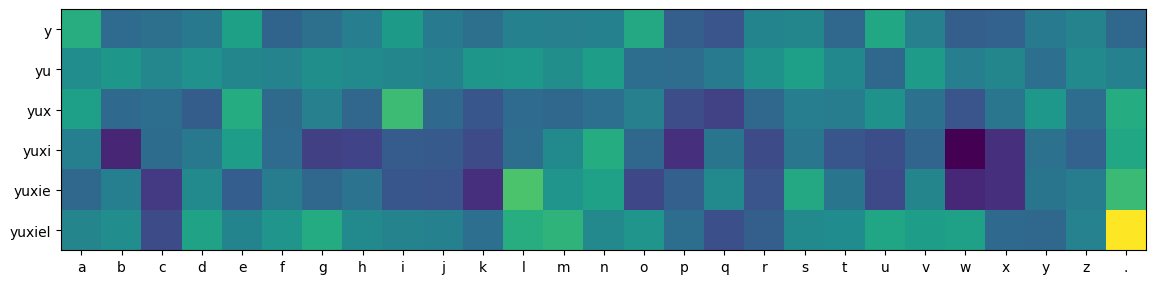

tyron
True 



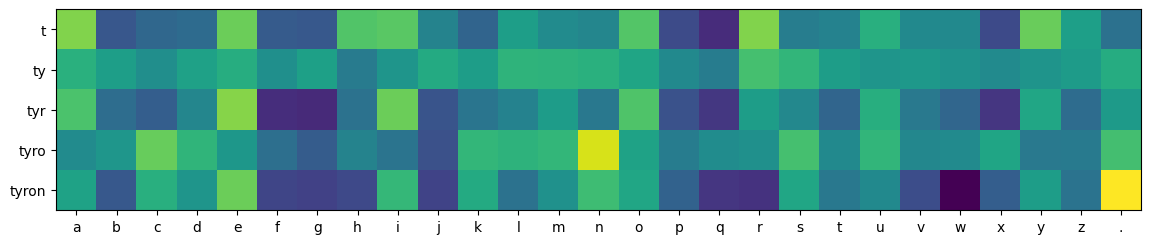

jekri
False 



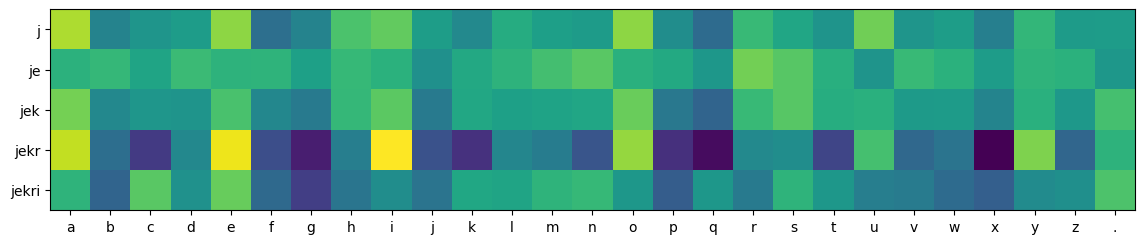

zar
False 



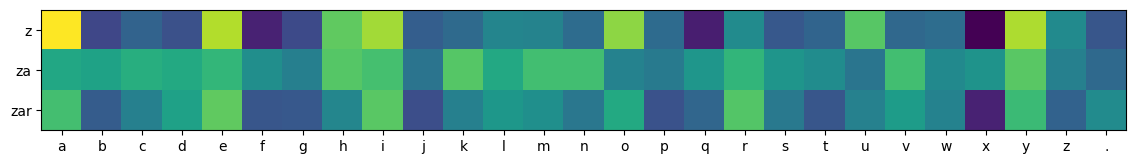

In [27]:
for _s in range(50):
    input_rnd = np.random.randint(0, 26)
    
    input = tensorise_sequence(itol[input_rnd])
    output = input
    out_l = itol[input_rnd]
    hidden = lstm.initHidden()
    cell_state = lstm.initCellState()
    seq = [itol[input_rnd]]
    graph_prob_out = torch.tensor([])
    graph_l = [out_l]
    while out_l != '.':
        output, hidden, cell_state = lstm(output.view(1, 27), hidden, cell_state)
        graph_prob_out = torch.cat((graph_prob_out ,output), 0)
        output = torch.multinomial(F.softmax(output, dim=1), 1).view(-1)
        out_l = itol[output.item()]
        graph_l.append(''.join(graph_l[-1]) + out_l)
        seq.append(itol[output.item()])
        output = tensorise_sequence(itol[output.item()])
    
    name = ''.join(seq[:-1])
    print(name)
    exists = (df[0] == name).any()
    print(True if (df[0] == name).any() else False, '\n')
    plot_prob(graph_prob_out.detach().numpy(), graph_l[:-1])

In [41]:
rnn_untrained = LSTM(27, 128, 27)
for _s in range(50):
    input_rnd = np.random.randint(0, 26)
    
    input = tensorise_sequence(itol[input_rnd])
    output = input
    out_l = itol[input_rnd]
    hidden = rnn_untrained.initHidden()
    cell_state = rnn_untrained.initCellState()
    seq = [itol[input_rnd]]
    while out_l != '.':
        output, hidden = rnn_untrained(output.view(1, 27), hidden, cell_state)
        output = torch.multinomial(F.softmax(output, dim=1), 1).view(-1)
        out_l = itol[output.item()]
        seq.append(itol[output.item()])
        output = tensorise_sequence(itol[output.item()])
    
    name = ''.join(seq[:-1])
    print(name)
    exists = (df[0] == name).any()
    print(True if (df[0] == name).any() else False, '\n')

heebz
False 

hqfiudzidvxnhmfvrsmvuixltuoftckwevejiobpambcwuytntzaujcefnmzzotecvbcmrdivyzpjhatedmtkdgrazakodlcsjdcrciyxltijutbbeicmxgncfeab
False 

aeezbrasqmfbudjlkuheumzmvmqjjvxikq
False 

djegjnuqwborlcifpfjrdgxuzzsbcbssuyjbd
False 

hzasinrpgfexgfqfesqywyioqhbltvsehmncpclrmyqqxsuskoqhovp
False 

mzzkenwkxswhjlcafgrqtqdaalnlqftjgwpzbhtfvusbkjryyeoasrwwjokzshnaogfzidygay
False 

m
False 

vmdwetsqfhufjviibkale
False 

rptiwapayemfhefonroyuhtjowakauyxhazyzesuqrmszxbfmkzflaymtpe
False 

mzocjfk
False 

bqe
False 

nssjmvinopog
False 

vahqnoptw
False 

srlpzxruclxnwk
False 

rcykfkjhwzqditjhtckfkszdtgyjufmjzhvy
False 

jkmlbmhewkkmcdqpziphzqzlaayuvlkyupikxytlpnqbsmwjqcqrqqsllysgastigghdjzfflsfeoaychuhzkr
False 

vufaznrwerog
False 

usxkfszlkpwzpezoggzbyr
False 

ui
False 

yqlfsnrgmuarfkszohbufnkxlvumjemuzrpkqtdzetuqsznllzdrniftq
False 

iuodgosswtlsfmevrgsxzlkxrrorxpusfxptzwwnlnnwnvbzkgtvglnguzwgulzvvzvzxec
False 

a
False 

jpzolhshlxhtmldckgawcczekiqzjzfmasqtrmrjvnfqzhnfpvkhfnylusp

In [34]:
p_count = 0

for p in lstm.parameters():
    p_count += p.numel()

print(p_count)

83355


In [19]:
#graph output prob
def plot_prob(graph_prob_out, graph_l):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.imshow(graph_prob_out, cmap='viridis')
    num_rows = graph_prob_out.shape[0]
    ax.set_yticks(np.arange(num_rows))
    ax.set_yticklabels([l for l in graph_l])
    
    ax.set_xticks(np.arange(27))
    ax.set_xticklabels([char for char in string.ascii_lowercase]+['.'])
    
    
    plt.show()